In [1]:
import os
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

from quantum.trainer import FashionMNISTQAETrainer

2025-11-23 12:18:57.436269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 12:18:57.459132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 12:18:57.976123: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
trainer = FashionMNISTQAETrainer(num_trash_qubits=1)
trainer.train(num_train=100, max_iterations=300, random_seed=42)
print(f"Training completed in {trainer.qae_model.training_time:.2f} seconds.")

2025-11-23 12:18:59.447952: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
100%|██████████| 60000/60000 [00:16<00:00, 3634.11it/s]
/home/pi/uw/QuantumAutoencode/classical/utils/data_loader.py:92: RuntimeWarning: invalid value encountered in divide
  patched_dataset = patched_dataset / norms


Training completed in 96.86 seconds.


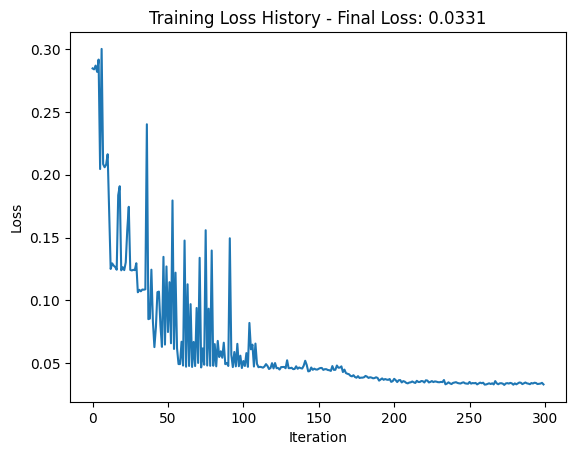

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=trainer.qae_model.training_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Training Loss History - Final Loss: {trainer.qae_model.training_history[-1]:.4f}")
plt.show()

In [12]:
# predict
import logging
logging.getLogger().setLevel(logging.INFO)

originals, predictions, mse_errors, fidelities = trainer.evaluate(num_test=5000)

100%|██████████| 10000/10000 [00:02<00:00, 3724.07it/s]
/home/pi/uw/QuantumAutoencode/classical/utils/data_loader.py:92: RuntimeWarning: invalid value encountered in divide
  patched_dataset = patched_dataset / norms
INFO:root:Keeping only unique patches in the dataset.
INFO:root:Test data shape: (5000, 64)
100%|██████████| 5000/5000 [00:19<00:00, 260.32it/s]
INFO:root:Prediction completed in 19.23 seconds.


In [6]:
import numpy as np

metadata = {
    "description": "",
    "num_sampled_trained_on": trainer.qae_model.num_sampled_trained_on
    if hasattr(trainer.qae_model, "num_sampled_trained_on")
    else "Unknown",
    "test_samples": "Not evaluated",
    "final_loss": trainer.qae_model.training_history[-1]
    if trainer.qae_model.training_history
    else None,
    "training_iterations": len(trainer.qae_model.training_history),
    "average_mse": float(np.mean(mse_errors)) if mse_errors is not None else None,
    "average_fidelity": float(np.mean(fidelities)) if fidelities is not None else None,
}

trainer.qae_model.save_model("saved_models/f_mnist_qae_100_1_trash", metadata=metadata)

('saved_models/f_mnist_qae_100_1_trash.json',
 'saved_models/f_mnist_qae_100_1_trash.pkl')

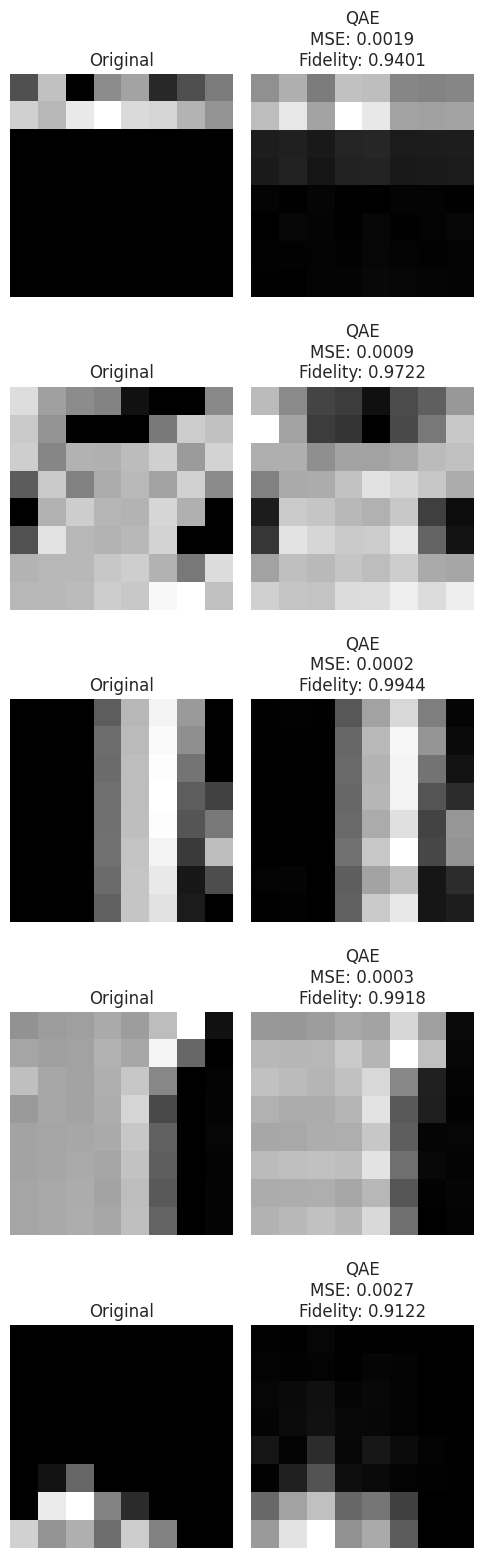

In [10]:
# plot results
fig, axes = plt.subplots(5, 2, figsize=(5, 5 * 3.2))
for i in range(5):
    axes[i, 0].imshow(originals[i].reshape(8, 8), cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(predictions[i].reshape(8, 8), cmap='gray')
    axes[i, 1].set_title(f"QAE\nMSE: {mse_errors[i]:.4f}\nFidelity: {fidelities[i]:.4f}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

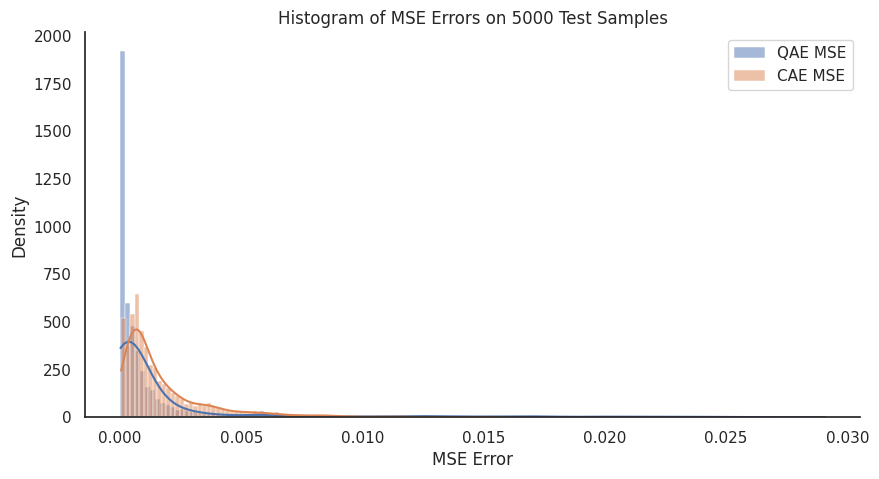

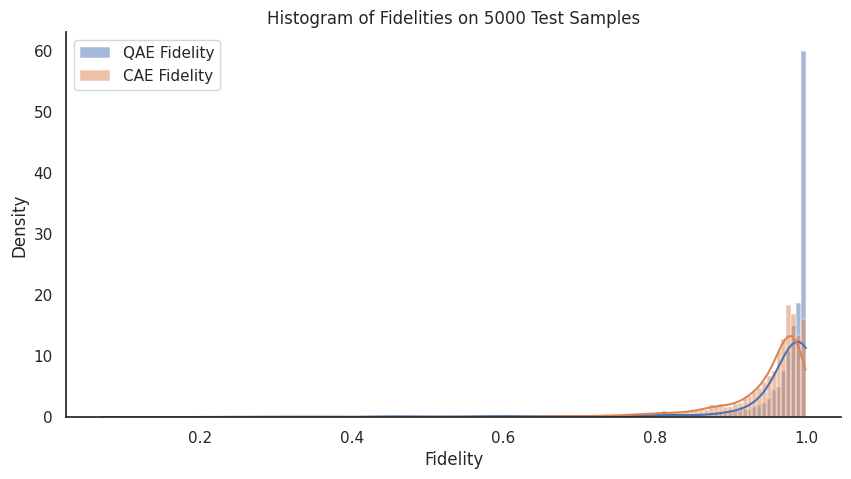

In [11]:
# plot histograms of fidelity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(rc=custom_params, style="white")

cae_mse_errors = np.load("f_mnist_cae_mse_errors.npy")
cae_fidelities = np.load("f_mnist_cae_fidelities.npy")

# MSE (overlapped histograms)
plt.figure(figsize=(10, 5))
sns.histplot(mse_errors, label='QAE MSE', kde=True, stat="density", alpha=0.5)
sns.histplot(cae_mse_errors, label='CAE MSE', kde=True, stat="density", alpha=0.5)
plt.title("Histogram of MSE Errors on 5000 Test Samples")
plt.xlabel("MSE Error")
plt.ylabel("Density")
plt.legend()
plt.show()

# Fidelity (overlapped histograms)
plt.figure(figsize=(10, 5))
sns.histplot(fidelities, label='QAE Fidelity', kde=True, stat="density", alpha=0.5)
sns.histplot(cae_fidelities, label='CAE Fidelity', kde=True, stat="density", alpha=0.5)
plt.title("Histogram of Fidelities on 5000 Test Samples")
plt.xlabel("Fidelity")
plt.ylabel("Density")
plt.legend()
plt.show()